# Generates Supp Fig 4 plots

In [1]:
import os
import sys
import pickle
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import seaborn as sns

from sklearn.linear_model import LassoLarsCV


sys.path.append('../common')
import data_io_utils
import paths
import constants
import utils
import plot_style_utils

sys.path.append('../A006_simulated_annealing/')
import A006_common
from unirep import babbler1900 as babbler

sys.path.append('../A003_policy_optimization/')
import A003_common

import A008_common

%reload_ext autoreload
%autoreload 2

# GFP

In [2]:
sark_file = os.path.join(data_io_utils.S3_DATA_ROOT, 'datasets/sarkisyan.csv')
data_io_utils.sync_s3_path_to_local(sark_file, is_single_file=True)

sark_df = pd.read_csv(sark_file)

In [3]:
nrep=1000
np.random.seed(42)
random.seed(42)

df = sark_df
wt_seq = constants.AVGFP_AA_SEQ
qfunc_col = 'quantitative_function'

wt_idx = np.argwhere(df['seq'] == wt_seq).reshape(-1)[0]
wt_qfunc = df.iloc[wt_idx][qfunc_col]

In [4]:
for N in [24, 96]:
    
    best_obs = []
    for i in range(nrep):
        sdf = df.sample(n=N)
        best_obs.append(np.max(sdf[qfunc_col]))
        
    print('N_train:', N, 'Avg fold improvement over WT:', np.mean(np.array(best_obs)/wt_qfunc))

N_train: 24 Avg fold improvement over WT: 1.037589270112721
N_train: 96 Avg fold improvement over WT: 1.0746987396072143


# BLAC

In [5]:
fdfs = []
for i in range(3):
    dfile = os.path.join(data_io_utils.S3_DATA_ROOT, 'datasets/tts_splits/data_distributions/firnberg_split_%d.csv' % i)
    data_io_utils.sync_s3_path_to_local(dfile, is_single_file=True)
    fdfs.append(pd.read_csv(dfile))
    
firn_df = pd.concat(fdfs)
print(firn_df.shape)

(5199, 2)


In [6]:
nrep=1000
np.random.seed(42)
random.seed(42)

df = firn_df
wt_seq = constants.BETA_LAC_AA_SEQ
qfunc_col = 'quantitative_function'

wt_idx = np.argwhere(df['seq'] == wt_seq).reshape(-1)[0]
wt_qfunc = df.iloc[wt_idx][qfunc_col]

In [7]:
for N in [24, 96]:
    
    best_obs = []
    for i in range(nrep):
        sdf = df.sample(n=N)
        best_obs.append(np.max(sdf[qfunc_col]))
        
    print('N_train:', N, 'Avg fold improvement over WT:', np.mean(np.array(best_obs)/wt_qfunc))

N_train: 24 Avg fold improvement over WT: 1.0097748706439171
N_train: 96 Avg fold improvement over WT: 1.031074399852674


In [8]:
np.log10(30)/np.log10(2)

4.906890595608519

In [9]:
np.log(30)/np.log(2)

4.906890595608519

## Hit rate vs nmut

In [10]:
PROT = 'GFP' # toggle this. Set to 'BLAC' to generate plots for beta-lactamase

In [11]:
if PROT == "BLAC":
    wt_seq = constants.BETA_LAC_AA_SEQ
    prot = 'BLAC'
    QFUNC_COL = 'lfe_1000'
    
    rmut_nmut = utils.levenshtein_distance_matrix([constants.BETA_LAC_AA_SEQ], list(firn_df['seq'])).reshape(-1)
    rmut_qfunc = np.array(firn_df['quantitative_function'])
    rmut_wt_qfunc  = rmut_qfunc[rmut_nmut == 0][0]
    
elif PROT == 'GFP':
    wt_seq = constants.AVGFP_AA_SEQ
    prot = 'GFP'
    QFUNC_COL = 'qfunc'
    
    rmut_nmut = utils.levenshtein_distance_matrix([constants.AVGFP_AA_SEQ], list(sark_df['seq'])).reshape(-1)
    rmut_qfunc = np.array(sark_df['quantitative_function'])
    rmut_wt_qfunc  = 1.000 # by definition

In [12]:
def load_protein_data(prot):
    if prot == 'BLAC':
        # Generated in mlpe-gfp-pilot repository
        lfe_data_file = os.path.join(data_io_utils.S3_DATA_ROOT, 'chip_1', 
                'A052e_BLAC_log_fold_enrichment.csv')
        data_io_utils.sync_s3_path_to_local(lfe_data_file, is_single_file=True)

        df = pd.read_csv(lfe_data_file)
        df['n_mut_rel_wt'] = utils.levenshtein_distance_matrix(
                [constants.BETA_LAC_AA_SEQ], list(df['seq'])).reshape(-1).astype(int)
        
        # Drop large radius since it was a small scale expt and we don't talk about it
        # in the paper
        df = df[df['n_mut_rel_wt'] <= 7]
        
        
    elif prot == 'GFP':
        inf_brightness_data_file = os.path.join(data_io_utils.S3_DATA_ROOT, 'chip_1', 
                'A052b_Chip_1_inferred_brightness_v2.csv')
        data_io_utils.sync_s3_path_to_local(inf_brightness_data_file, is_single_file=True)

        df = pd.read_csv(inf_brightness_data_file)
        #df.index = df['id']
        df.at[df['id'] == 'avGFP', 'seq'] = constants.AVGFP_AA_SEQ
        df.at[df['id'] == 'sfGFP', 'seq'] = constants.SFGFP_AA_SEQ
        df['n_mut_rel_wt'] = utils.levenshtein_distance_matrix(
                [constants.AVGFP_AA_SEQ], list(df['seq'])).reshape(-1).astype(int)

    q = df['id'].apply(lambda s: pd.Series(A008_common.split_seq_id_into_features(s)))
    df = df.merge(q, left_index=True, right_index=True)
    
    if prot == 'GFP':
        df.at[df['id'] == 'avGFP', 'model'] = 'ignore'
        df.at[df['id'] == 'sfGFP', 'model'] = 'ignore'
    
    
    # Remove Grigory's greedy designs
    mask = np.array([isinstance(m, str) for m in df['model']])
    mask = np.logical_or(np.logical_or(mask, df['id'] == 'avGFP'), df['id'] == 'sfGFP')
    df = df[mask]
    
    
    
    display(df.head())
    print(df.columns)
    
    return df

In [13]:
df = load_protein_data(prot)

if prot == 'GFP':
    df[QFUNC_COL] = df[QFUNC_COL] - np.min(df[QFUNC_COL])

,id,qfunc,qfunc_rep1,qfunc_rep2,extracted_lib_nt_seq,seq_idx,trajectory_idx,predicted_fitness,ensemble_predicted_fitness,seq,...,DE_Chip_1_GFP_NGS_15,DE_Chip_1_GFP_NGS_16,DE_Chip_1_GFP_NGS_17,DE_Chip_1_GFP_NGS_18,model,ntrain,rep,rep_hash,seq_traj_idx,special_case
0,GFP_SimAnneal-ET_Global_Init_2-0024-04-36079a2...,2.205245,2.335832,2.205245,AAAACAGAGGGTCCTAGAGACGCAACTTATGGTAAAATGACGCCGA...,2719.0,1741.0,9.660326e+07,[-4.4425168e+00 -4.4221644e+00 -5.1892853e+00 ...,MSKGEELFTGVVPILVELDGDVNGHKFSVKTEGPRDATYGKMTPKF...,...,0.0,0.0,0.0,0.0,ET_Global_Init_2,24.0,4.0,36079a2c,seq_idx_2719_1741,
1,GFP_SimAnneal-OneHot-0024-04-4279eeb-seq_idx_2...,1.945739,2.011986,1.945739,AAAACAGAGGGTGAAGGTGACGCAACTTATGGTAAACTGAGCCTGA...,2601.0,1191.0,7.883185e-01,[0.73590547 0.76271843 0.77913585 0.75764891 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKTEGEGDATYGKLSLKF...,...,0.0,0.0,0.0,0.0,OneHot,24.0,4.0,4279eeb,seq_idx_2601_1191,
2,GFP_SimAnneal-ET_Random_Init_1-0024-04-1989c09...,2.079981,2.279340,2.079981,AAAATGGAGGGTGAAGGTAATCCTACTGGTGGTAAACTGATTCAGA...,454.0,2029.0,7.540600e-01,[0.7710203 0.7359552 0.6161216 0.77072877 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKMEGEGNPTGGKLIQKF...,...,0.0,0.0,0.0,0.0,ET_Random_Init_1,24.0,4.0,1989c098,seq_idx_454_2029,
3,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.180828,2.236717,2.180828,AAAGGCATAGGTGAAGGTGACGCAACTATGGGTAAACTGACGATTC...,1809.0,1276.0,7.377951e-01,[1.0700963 0.7323966 0.79640985 0.7426758 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKGIGEGDATMGKLTIRF...,...,5.0,0.0,0.0,0.0,ET_Global_Init_1,24.0,4.0,4502d3,seq_idx_1809_1276,
4,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.670093,2.670093,2.720217,AAAGGCCAAGGTGAAGGTGAAGCAACTTATGGTAAACTGACGCTGA...,317.0,3482.0,7.378049e-01,[0.9574555 0.7345054 0.7397466 0.7718942 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGEATYGKLTLKF...,...,13.0,1.0,1.0,0.0,ET_Global_Init_1,24.0,4.0,4502d3,seq_idx_317_3482,


Index(['id', 'qfunc', 'qfunc_rep1', 'qfunc_rep2', 'extracted_lib_nt_seq',
       'seq_idx', 'trajectory_idx', 'predicted_fitness',
       'ensemble_predicted_fitness', 'seq', 'protein', 'pred_score',
       'lib_aa_seq', 'constant_where_expected', 'successfully_clones',
       'error_message', 'dna_to_order', 'ligated_gene',
       'ligated_gene_translated', 'n_mut_rel_wt', 'oligo_len',
       'DE_Chip_1_GFP_NGS_01', 'DE_Chip_1_GFP_NGS_02', 'DE_Chip_1_GFP_NGS_03',
       'DE_Chip_1_GFP_NGS_04', 'DE_Chip_1_GFP_NGS_05', 'DE_Chip_1_GFP_NGS_06',
       'DE_Chip_1_GFP_NGS_07', 'DE_Chip_1_GFP_NGS_08', 'DE_Chip_1_GFP_NGS_09',
       'DE_Chip_1_GFP_NGS_10', 'DE_Chip_1_GFP_NGS_11', 'DE_Chip_1_GFP_NGS_12',
       'DE_Chip_1_GFP_NGS_13', 'DE_Chip_1_GFP_NGS_14', 'DE_Chip_1_GFP_NGS_15',
       'DE_Chip_1_GFP_NGS_16', 'DE_Chip_1_GFP_NGS_17', 'DE_Chip_1_GFP_NGS_18',
       'model', 'ntrain', 'rep', 'rep_hash', 'seq_traj_idx', 'special_case'],
      dtype='object')


In [14]:
if prot == 'GFP':
    WT_QFUNC = df[df['id'] == 'avGFP'][QFUNC_COL].iloc[0]
if prot == 'BLAC':
    WT_QFUNC = df[df['seq'] == constants.BETA_LAC_AA_SEQ][QFUNC_COL].iloc[0]

In [15]:
plot_style_utils.set_pub_plot_context()

In [16]:
def calc_hit_rate_vs_nmut(qfuncs, nmuts, wt_qfunc):
    unmuts, cts = np.unique(nmuts, return_counts=True)
    cts = cts[unmuts > 0]
    unmuts = unmuts[unmuts > 0]
    
    
    hr = np.array([np.sum(qfuncs[nmuts==n] > wt_qfunc)/len(qfuncs[nmuts==n]) for n in unmuts])
    
    hw = 1.96*np.sqrt(hr*(1-hr)/cts) # half width of 95% CI.
    
    
    sidx = np.argsort(unmuts)
    return unmuts[sidx], hr[sidx], hw[sidx]

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


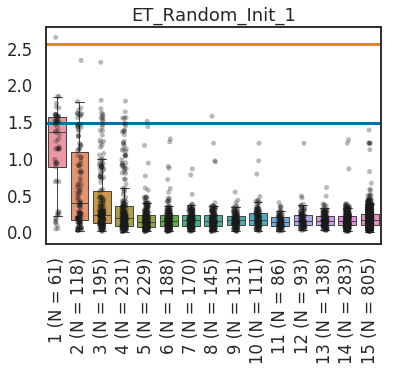

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


ET_Random_Init_1 Fold_change WT_thresh: [1.9922076  0.50640998 0.42489366 0.38513777 0.12522476 0.
 0.         1.88137931 0.                nan        nan        nan
        nan        nan        nan]
ET_Random_Init_1 Fold_change WT_thresh x 1.3: [79.96721311 31.5815678  15.81666667  8.12640693  0.                 nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan]


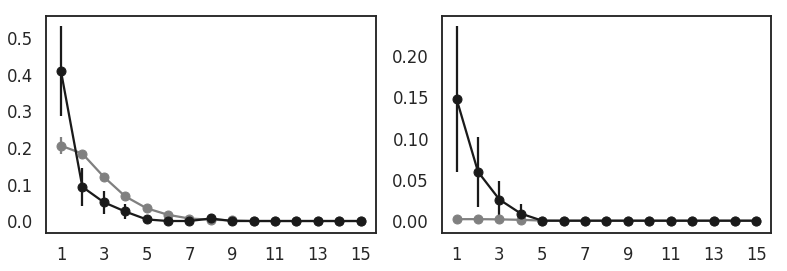

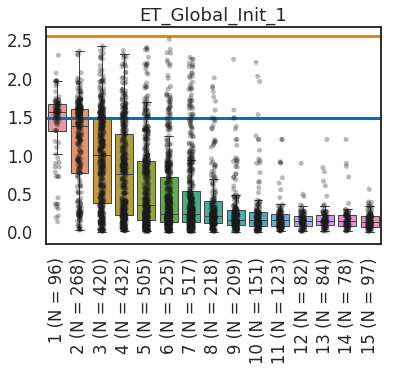

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


ET_Global_Init_1 Fold_change WT_thresh: [ 3.19002242  2.31079615  2.16999264  2.60859517  2.66889924  3.92511416
 10.63397429 11.26238532 12.                 inf         nan         nan
         nan         nan         nan]
ET_Global_Init_1 Fold_change WT_thresh x 1.3: [220.1875     143.0261194   92.5275     110.80694444 418.96039604
          inf          inf          inf          inf          inf
          nan          nan          nan          nan          nan]


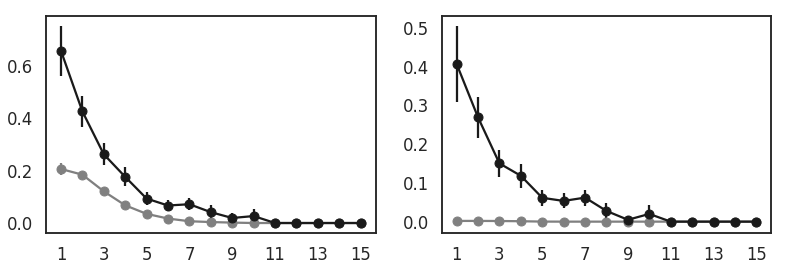

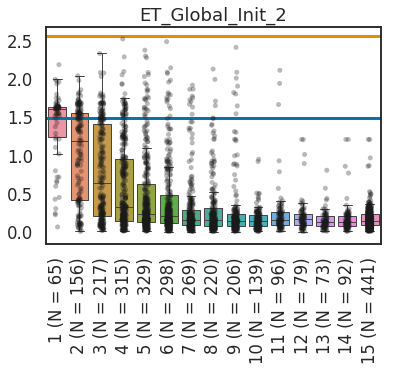

ET_Global_Init_2 Fold_change WT_thresh: [ 3.29051397  1.91526851  1.64181262  1.553389    2.17906311  3.16116576
  5.52372622  6.2        24.34951456         nan         inf         nan
         nan         nan         nan]
ET_Global_Init_2 Fold_change WT_thresh x 1.3: [275.16923077 102.37980769  71.0656682   62.57333333 435.63829787
          inf          inf          inf          inf          nan
          inf          nan          nan          nan          nan]


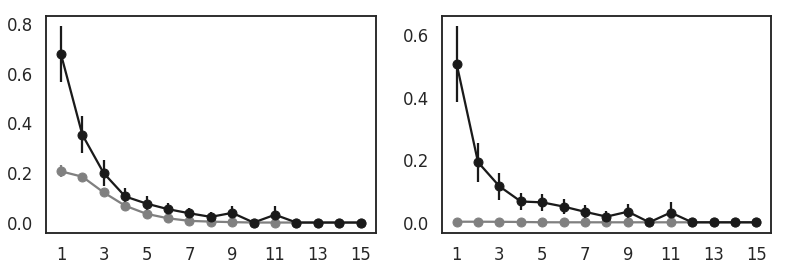

In [17]:
np.random.seed(42)
random.seed(42)

models = list(set(np.unique(df['model'])) - {'ignore'})

for m in models:
    if 'ET' not in m:
        continue
    
    mdf = df[df['model'] == m]
    mdf = mdf[mdf['n_mut_rel_wt'] > 0]
    
    nmut2n = {u: np.sum(mdf['n_mut_rel_wt'] == u) for u in np.unique(mdf['n_mut_rel_wt'])}

    
    fig = plt.figure()
    sns.stripplot(x='n_mut_rel_wt', y=QFUNC_COL, data=mdf, 
                  color='k', alpha=0.3)
    sns.boxplot(x='n_mut_rel_wt', y=QFUNC_COL, data=mdf, 
                linewidth=1, whis=1, fliersize=0)
    
    label_nmuts = [int(l._text) for l in plt.gca().get_xticklabels()]
    updated_labels = [str(n) + ' (N = %d)'%nmut2n[n] for n in label_nmuts]
    plt.gca().set_xticklabels(updated_labels, rotation=90)
    
    if prot == 'GFP':
        AVGFP_QFUNC = WT_QFUNC
        SFGFP_QFUNC = df[df['id'] == 'sfGFP']['qfunc'].iloc[0]
        plt.axhline(AVGFP_QFUNC, color=plot_style_utils.CAT_PALETTE[0], linewidth=3)
        plt.axhline(SFGFP_QFUNC, color=plot_style_utils.CAT_PALETTE[1], linewidth=3)
    if prot == 'BLAC':
        plt.axhline(WT_QFUNC, color=plot_style_utils.CAT_PALETTE[0], linewidth=3)
    
    plt.xlabel('')
    plt.ylabel('')
    plt.title(m)
    plt.show()
    
    
    plot_style_utils.save_for_pub(fig=fig, path='figures/A008f/qfunc_vs_nmut_' + prot + '_' + m)
    
    
    fig = plt.figure(figsize=(13,4))
    
    plt.subplot(1,2,1)
    rnm, rhr, rhw = calc_hit_rate_vs_nmut(rmut_qfunc, rmut_nmut, rmut_wt_qfunc)
    nm, hr, hw = calc_hit_rate_vs_nmut(mdf[QFUNC_COL], mdf['n_mut_rel_wt'], WT_QFUNC)
    if PROT == 'GFP':
        plt.errorbar(rnm, rhr, yerr=rhw, fmt='-o', color=[0.5, 0.5, 0.5])
    plt.errorbar(nm, hr, yerr=hw, fmt='-ok')
    plt.xticks(np.arange(1, np.max(mdf['n_mut_rel_wt'])+1, 2))
    print(m, 'Fold_change WT_thresh:', hr/rhr)
    
    plt.subplot(1,2,2)
    rnm, rhr, rhw = calc_hit_rate_vs_nmut(rmut_qfunc, rmut_nmut, rmut_wt_qfunc + np.log10(1.3))
    nm, hr, hw = calc_hit_rate_vs_nmut(mdf[QFUNC_COL], mdf['n_mut_rel_wt'], WT_QFUNC+ np.log10(1.3))
    if PROT == 'GFP':
        plt.errorbar(rnm, rhr, yerr=rhw, fmt='-o', color=[0.5, 0.5, 0.5])
    plt.errorbar(nm, hr, yerr=hw, fmt='-ok')
    plt.xticks(np.arange(1, np.max(mdf['n_mut_rel_wt'])+1, 2))
    print(m, 'Fold_change WT_thresh x 1.3:', hr/rhr)
    
    plt.show()
    
    plot_style_utils.save_for_pub(fig=fig, path='figures/A008f/hitrate_vs_nmut_' + prot + '_' + m)
    
    